## 1. IMPORTATION DES BIBLIOTHÈQUES NÉCESSAIRES

In [4]:
import pandas as pd
import numpy as np
import joblib

# Pour la modélisation et la préparation des données
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Pour l'évaluation des performances
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

## 2. Chargement des données

In [7]:
print("--- 2. Chargement des données nettoyées et préparation ---")

# Chargement du fichier CSV déjà nettoyé et encodé
try:
    df_clean = pd.read_csv('diabetes_clean.csv')
    print("Fichier 'diabetes_clean.csv' chargé avec succès.")
except FileNotFoundError:
    print("ERREUR : Le fichier 'diabetes_clean.csv' est introuvable. Assurez-vous qu'il est dans le répertoire de travail.")
    exit()

# Séparation des features (X) et de la cible (y)
X = df_clean.drop('class', axis=1)
y = df_clean['class']

print(f"Features (X) : {X.shape}")
print(f"Cible (y) : {y.shape}")

--- 2. Chargement des données nettoyées et préparation ---
Fichier 'diabetes_clean.csv' chargé avec succès.
Features (X) : (416, 16)
Cible (y) : (416,)


## 3. SPLIT DES DONNÉES (TRAIN/TEST)

In [8]:
print("\n--- 3. Split des données (Train/Test) ---")

# Séparation en ensembles d'entraînement (80%) et de test (20%)
# stratify=y est crucial pour préserver la répartition des classes (Positive/Negative)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Taille de l'ensemble d'entraînement : {X_train.shape[0]} échantillons")
print(f"Taille de l'ensemble de test : {X_test.shape[0]} échantillons")



--- 3. Split des données (Train/Test) ---
Taille de l'ensemble d'entraînement : 332 échantillons
Taille de l'ensemble de test : 84 échantillons


## 4. PRÉTRAITEMENT (SCALING) - UNIQUEMENT SUR LA COLONNE 'AGE'

In [9]:
print("\n--- 4. Standardisation de la colonne 'age' ---")

# Définition des colonnes à transformer
numerical_features = ['age']
# Toutes les autres colonnes sont binaires (0/1) et n'ont pas besoin de scaling
binary_features = X_train.columns.drop(numerical_features).tolist()

# Création du préprocesseur pour appliquer StandardScaler uniquement à 'age'
preprocessor = ColumnTransformer(
    transformers=[
        # Applique StandardScaler (Z-score normalisation) uniquement à la colonne 'age'
        ('scaler', StandardScaler(), numerical_features)
    ],
    remainder='passthrough' # Laisse les colonnes binaires intactes
)


--- 4. Standardisation de la colonne 'age' ---


## 5. ENTRAÎNEMENT DU MODÈLE (FORET ALÉATOIRE)

In [10]:
print("\n--- 5. Entraînement du Modèle Final (Forêt Aléatoire) ---")

# Justification : La Forêt Aléatoire est choisie pour sa haute performance, 
# sa robustesse face au surapprentissage et sa capacité à gérer le déséquilibre 
# des classes avec 'class_weight'.

# Définition du modèle final dans un Pipeline (pour inclure le préprocesseur)
best_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced' # Aide à compenser le léger déséquilibre des classes
)

# Création du pipeline complet : Préprocesseur -> Modèle
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

# Entraînement du pipeline sur l'ensemble d'entraînement
final_pipeline.fit(X_train, y_train)

print("Pipeline d'entraînement terminé.")


--- 5. Entraînement du Modèle Final (Forêt Aléatoire) ---
Pipeline d'entraînement terminé.


## 6. ÉVALUATION DES PERFORMANCES


--- 6. Évaluation des Performances ---

--- Rapport de Classification (Random Forest) ---
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        32
           1       0.96      0.98      0.97        52

    accuracy                           0.96        84
   macro avg       0.97      0.96      0.96        84
weighted avg       0.96      0.96      0.96        84

AUC (Area Under the Curve) : 0.9949
Recall (Rappel/Sensibilité) pour la classe Positive : 0.9808
F1-Score pour la classe Positive : 0.9714


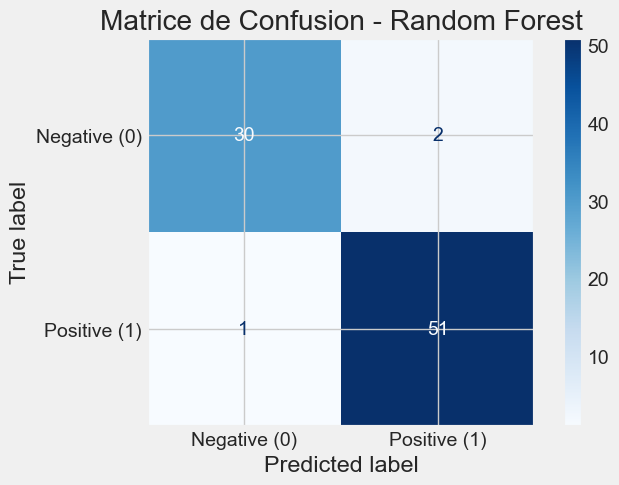

In [11]:
print("\n--- 6. Évaluation des Performances ---")

# Prédictions sur l'ensemble de test
y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)[:, 1]

# Métriques clés
auc_score = roc_auc_score(y_test, y_proba)

# Rapport de Classification (incluant Precision, Recall, F1)
print("\n--- Rapport de Classification (Random Forest) ---")
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

# Affichage des métriques spécifiques demandées
recall_positive = report['1']['recall'] # Rappel pour la classe Positive (1)
f1_positive = report['1']['f1-score'] # F1 pour la classe Positive (1)

print(f"AUC (Area Under the Curve) : {auc_score:.4f}")
print(f"Recall (Rappel/Sensibilité) pour la classe Positive : {recall_positive:.4f}")
print(f"F1-Score pour la classe Positive : {f1_positive:.4f}")

# Affichage de la Matrice de Confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative (0)', 'Positive (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion - Random Forest")
plt.show()


## 7. SAUVEGARDE DU MODÈLE (LIVRABLE .pkl)

In [12]:
print("\n--- 7. Sauvegarde de l'Artefact Modèle (.pkl) ---")

# Ré-entraînement sur l'ensemble complet des données (X et y) avant la sauvegarde finale (pratique courante)
final_pipeline.fit(X, y)

# Sauvegarde du pipeline complet (préprocesseur + modèle)
artifact_filename = 'modele_diabete_XX.pkl' # 🚨 N'oubliez pas de remplacer XX par vos initiales
joblib.dump(final_pipeline, artifact_filename)

print(f"Succès : L'artefact modèle a été sauvegardé sous le nom '{artifact_filename}'")
print("\n--- FIN DU PROJET ---")


--- 7. Sauvegarde de l'Artefact Modèle (.pkl) ---
Succès : L'artefact modèle a été sauvegardé sous le nom 'modele_diabete_XX.pkl'

--- FIN DU PROJET ---
